<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for dimensionality reduction 
  - [3.2](#q32) Community detection


<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)



In [46]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from copy import deepcopy

In [14]:
MASTER_SEED = 42

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data()

In [15]:
#Progress bar will be useful to gauge how long until algorithm completes
def progress_bar(progress, goal, prepend_str="", steps=20, done_chr=chr(0x25A0), prog_chr=chr(0x2022), empty_chr = chr(0x2022)):
    """
    Creates a progress bar of specified length.

    Args:
        progress           (int): The currect progress of the task begin measured.
        goal               (int): Marker for when progress denotes a completed task.
        prepend_str     (String): String preceding progress bar.                             Defaults to "".
        steps              (int): The number of steps (notches) on the progress bar.         Defaults to 20.
        done_chr        (String): 'Progress bar' character used to display current progress. Defaults to ■.
        prog_chr        (String): Character displayed at the final bar notch.                Defaults to •.
        empty_chr       (String): character used to display remaining progress.              Defaults to •.
    """

    # Convert to float here to allow str based inputs (This way floating-point precision displayed can be controlled)
    norm_prog = float(progress) / float(goal)
    
    bar_prog = int(norm_prog * steps)
    rem_prog = steps - bar_prog
        
    prog_str = (done_chr * bar_prog) + prog_chr + (empty_chr * rem_prog)

    #If progress bar is not complete, then move cursor to start of line so that next call may override printed text
    end = "\r" if bar_prog < steps else ""
    
    print("{}[{}/{}][{}]{:.0%}".format(prepend_str, progress, goal, prog_str[:steps], norm_prog), flush=True, end=end)


In [16]:
print("Image width:", x_train.shape[1], " height:", x_train.shape[2])

Image width: 28  height: 28


<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)



### 1.1.1 Creating the MLP

The above data `(x_train, y_train)` will be used to train a MLP network, with five HLs (Hidden Layers), 400 neurons per HL and ten output neurons. The data in question is a set of 28x28 pixel pictures with ten potential non-overlapping classifications, hence the input layer will consist of exactly 784 neurons. The activation function, on each of the hidden layers, will be chosen to be LeakyReLU with a slope of $10^{-2}$, which is as defined below:

$$
f(x) = \text{LeakyReLU(x)} = \begin{cases}x & x \geq 0 \\ 10^{-2} \cdot x & x < 0 \end{cases}
$$

$$
f'(x) = \begin{cases}1 & x \geq 0 \\ 10^{-2}  & x < 0 \end{cases}
$$


In [17]:
def LeakyRelUPrime(x, slope = 0.01):
    #result = slope if x < 0 otherwise 1
    return np.where(x < 0, slope, 1)

def LeakyReLU(x, slope=0.01):
    return x * LeakyRelUPrime(x, slope)


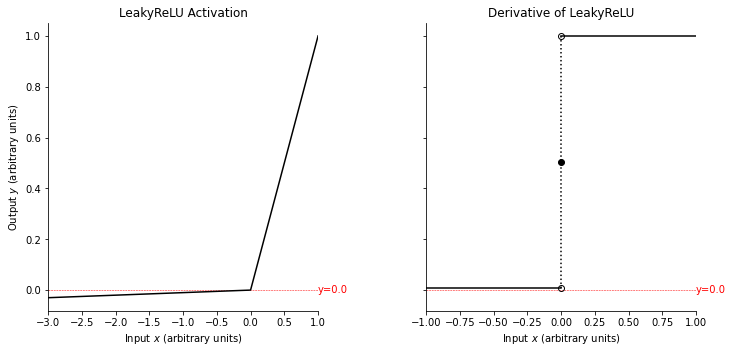

In [18]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots(sharey=True)
fig.subplots_adjust(
    left=0, 
    bottom=0, 
    right=1.5, 
    top=1, 
    wspace=0.4)

for ax in axs:
    #remove right and top sides of rectangling bounding the plots
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #make clear where the line y=0 is
    ax.axhline(y=0, color="red", linestyle="dashed", linewidth=0.5)
    ax.text(1, 0, "y=0.0", color = "red", va = "center")

    ax.set_xlabel("Input $x$ (arbitrary units)")


axs[0].title.set_text("LeakyReLU Activation")
axs[0].set_ylabel("Output $y$ (arbitrary units)")
axs[0].set_xlim(-3, 1)
x0 = np.linspace(*axs[0].get_xlim(), 1001)
axs[0].plot(x0, LeakyReLU(x0), color = "black")


axs[1].title.set_text("Derivative of LeakyReLU")
axs[1].set_xlim(-1, 1)
x1 = np.linspace(*axs[1].get_xlim(), 1000)
sx1 = np.split(x1, 2)
for x in sx1:
    axs[1].plot(x, LeakyRelUPrime(x), color = "black")

#Plot inequality markers
axs[1].plot(0     , (1e-2 + 1)/2, color = 'black', marker = "o")
axs[1].plot(0     , 1e-2        , color = 'black', marker = "o", fillstyle = "none")
axs[1].plot(0     , 1           , color = 'black', marker = "o", fillstyle = "none")
#Plot line connecting discontinuity
axs[1].plot([0, 0], [1e-2, 1]   , color = 'black', linestyle="dotted")

plt.show()

Furthermore, the output will undergo a softmax transformation given by:

$$
\text{softmax($x^{(k)}$)}_j = \frac{exp(x^{(k)}_j)}{\sum_{i=1}^{n_k} exp(x_i^{(k)})}
$$

Where $k$ will denote the output layer, hence $n_k$ the number of nodes (or equivalently outputs). And, $1 \leq j \leq n_k$ the $j^{th}$ output. Furthermore, the metric for error will be given by (categorical) cross-entropy given, in compact form, by:

$$
    \text{CE}(y, \hat{y}) = -y \cdot \log(\hat{y})
$$

With $y = e_i$ for some $i \in \mathbb{N}$, the correct category for the predictors, and $\hat{y} \in \Delta$ $\left(\text{i.e. } \sum_i \hat{y}_i = 1\right)$, the prediction of the category, is given as a probability vector. Of course, since $y_i = 1$ for only one $i$ and zero for all other entries. The cross entropy could be rewritten as:

$$
    \text{CE}(y, \hat{y}) = -\log(\hat{y_i}), \text{ where $i$ is such that $y_i=1$}
$$

In [19]:
def cat_cross_entropy(y_pred, y_actual):
    """
    Returns the cross entropy cost of the input prediction 'y_pred'.

    Args:
        y_pred   (array_like): The prediction (as a probability vector) of the input data.
        y_actual (array_like): The actual category of the data as a basis vector.

    Returns:
        (Integer): The cross entropy error
    """

    #Argmax should always return the index of the entry equal to 1 (Since this is the largest entry)
    category = np.argmax(y_actual, axis = -1)
    #numpy.choose here allows for proper broadcasting of indexing operator    
    return -np.log(np.choose(category, np.transpose(y_pred)))

In [20]:
def softmax(activations):
    """ Returns the softmax of the input 'activations' """

    e_activations = np.exp(activations)
    return e_activations / np.sum(e_activations, axis = -1)[..., np.newaxis]

#Simple testing to ensure correct functionality
test1 = np.array([1, 2])
test1_r = softmax(test1)
assert((test1_r == np.array([np.exp(1), np.exp(2)])/(np.exp(1) + np.exp(2))).all())

#Test correct broadcasting!
test2 = np.array([[1, 2], [3, 5], [8, 20]])
test2_r = softmax(test2)
for test_row, result_row in zip(test2, test2_r):
    assert((result_row == softmax(test_row)).all())


The training will be done by back propagation, first the activation and the pre-activation of all of the layers will be calculated using the following (vectorised) equations:

$$
\mathbf{a}^{(k+1)} = \mathbf{W}^{(k)}\mathbf{h}^{(k)} + \mathbf{b}^{(k)},\hspace{1em} \mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}), \hspace{1em} \mathbf{h}^{(0)} = \mathbf{x}
$$

With the superscript representing the layer upon which the variables have effect. Taking $L_i$ to be the loss function for training sample $i$, successful back propogation requires the initial error to be calculated:

$$
\begin{split}
L_i(\mathbf{a}^{(L+1)}) = CE(\mathbf{y}, \text{softmax($\mathbf{a}^{(L + 1)}$)}) &= -\sum_{i} y_i \log\left(\frac{exp(a^{(L + 1)}_i)}{\sum_{j} exp(a_j^{(L+1)})}\right)\\
&= - \sum_i y_i a^{(L + 1)}_i + \sum_i y_i\log\left(\sum_{j} exp(a_j^{(L+1)})\right) \\
&= - \sum_i y_i a^{(L + 1)}_i + \log\left(\sum_{j} exp(a_j^{(L+1)})\right)\sum_i y_i
\end{split}
$$

Looking at the second term on the right hand side, the sum over the entries of $ y$ evaluates to one, hence the above can be readily simplified to:

$$
L_i(\mathbf{a}^{(L+1)}) = - \sum_i y_i a^{(L + 1)}_i + \log\left(\sum_{j} exp(a_j^{(L+1)})\right)
$$

Taking the derivative with respect to $ a^{L+1}_k$ where $k$ can vary freely across all entries:

$$
\begin{split}
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial a^{(L_1)}_k} &= -y_k + \frac{exp(a^{(L + 1)}_k)}{\sum_{j} exp(a_j^{(L+1)})}\\
&= -y_k + \text{softmax($\mathbf{a}^{(L + 1)}$)})_k
\end{split}
$$

Writting the above in vectorised form gives:

$$
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial \mathbf{a}^{(L+1)}} = \text{softmax($\mathbf{a}^{(L + 1)}$)})-y
$$

The above may be simplified even further by noticing that the models last layer activation function, for this particular case, is the softmax function. Indeed, the prediction of the network may be written as $\hat{\mathbf{y}}=$ softmax $(\mathbf{a}^{(L + 1)})$. Hence, the final derivates can be compactly and succinctly written in the form:

$$
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial a^{(L+1)}} = \hat{\mathbf{y}}-\mathbf{y}
$$

With this, the following recursive relation provides the partial derivatives for the entire network. For simplicity, define: $\frac{\partial L_i(a^{(k)})}{\partial a^{(k)}} = \boldsymbol{\delta}^{(k)}$ and similarly $\frac{\partial L_i(a^{(k)})}{\partial a^{(k)}_i} = \delta^{(k)}_i$:

$$
\boldsymbol{\delta}^{(k)} = diag\left(\sigma'(a^{(k)}_1), \dots, \sigma'(a^{(k)}_{n_k})\right) \left(\mathbf{W}^{(k)}\right)^T \delta^{(k + 1)}
$$
$$
\begin{split}
\frac{\partial L_i}{\partial \mathbf{W}^{(k)}} &= \boldsymbol{\delta}^{(k + 1)} \left(\mathbf{h}^{(k)}\right)^T \\
\frac{\partial L_i}{\partial \mathbf{b}^{(k)}} &= \boldsymbol{\delta}^{(k + 1)}
\end{split}
$$

In [21]:
def CE_softmax_error(y_pred, y_actual):
    """Returns delta (error) of output layer for cross entropy with softmax"""

    return y_pred - y_actual

In [22]:
def create_network(neuron_dist, mean = 0):
    """
    Initialises a neural network with normally distributed weights.

    Args:
        neuron_dist (array): An integer array of the distribution of neurons per layer.
        mean        (float): The mean with which to generate the random weights.        Defaults tos 0.  

    Returns:
        (tuple): A tuple wherein the first and second elements are lists of (np.array) matricies and
        vectors represent the weights and biases of each layer, respectively.
    """

    #Function to shorten long comprehension list
    def normal_f32(prev_layer, curr_layer):
        """Returns normally distributed weights for 'curr_layer'"""

        #Standard deviation
        std = np.sqrt(2/(prev_layer + curr_layer))

        return np.random.normal(mean, std, (prev_layer, curr_layer)).astype(np.float32)
    
    weights = [normal_f32(prev, curr) for prev, curr in zip(neuron_dist, neuron_dist[1:])]
    biases  = [np.zeros(curr, dtype=np.float32) for curr in neuron_dist[1:]]

    return (weights, biases)

In [23]:
def forward_propagate(network, activation_func, input):
    """
    Forward propogate 'network'

    Args:
        network                      (tuple): The neural network as the tuple (weights, biases).
        activation_func (Function(np.array)): The activation function for the hidden layers.
        input                     (np.array): The activations for the input layer of the network

    Returns:
        (array, array): A list of pre activations and post activations at each layer. Note:
        output activation is not applied to final activation! 
    """

    # zeros inserted into pre_acts to ensure resulting array length matches
    # post_acts, hence each index represents pre activation and post
    # activation of each layer.    
    pre_acts  = [np.zeros(input.shape)]
    post_acts = [input]

    for weights, biases in zip(*network):
        a = post_acts[-1] @ weights + biases
        h = activation_func(a)

        pre_acts.append(a)
        post_acts.append(h)

    return pre_acts, post_acts

In [24]:
def network_output(network, activation_func, output_func, input):
    """
    Returns the networks assigned probability that the 'input' data is a given category. 

    Args:
        network                      (tuple): The neural network as the tuple (weights, biases).
        activation_func (Function(np.array)): The activation function for the hidden layers.
        output_func     (Function(np.array)): The activation function for the outout layer.
        input                     (np.array): The activations for the input layer of the network

    Returns:
        (np.array): A probability vector, where each index represents the networks confidence
        that the input data is the given (labelled) category.
    """

    post_acts = forward_propagate(network, activation_func, input)[1]
    return output_func(post_acts[-1])


In [25]:
def outer(lhs, rhs):
    """Broadcastable outer product"""

    return lhs[..., np.newaxis] * rhs[...,np.newaxis,:]

#Testing the outer function produces correct results:
test11 = np.array([1, 2])
test12 = np.array([3, 4])

assert((outer(test11, test12) == np.outer(test11, test12)).all())

#Testing broadcasting works correctly
test21 = np.array([[1, 2], [3, 4]])
test22 = np.array([[5, 6], [7, 8]])
test2_r = outer(test21, test22)

for test21_row, test22_row, test2_r_row in zip(test21, test22, test2_r):
    assert((test2_r_row == np.outer(test21_row, test22_row)).all())

In [26]:

def back_propogate(network, delta, pre_acts, post_acts, activation_prime):
    """
    Returns the derivative of the weights and biases of the network through back propogation.
    Note: A forward propogation needs to be performed first to acquire the pre-activations and
    post-activations.

    Args:
        network                       (tuple): The neural network as the tuple (weights, biases).
        delta                           (int): The last layer delta (error).
        pre_acts                       (list): The pre-activations of the forward propogation.
        post_acts                      (list): The post-activations of the forward propogation.
        activation_prime (Function(np.array)): The total derivative of the activation function 
                                               for the hidden layers.
    """

    del_ws = []
    del_bs = []

    # inital error is the output layer's delta, each element
    errors = [delta]

    for i, weights in reversed(list(enumerate(network[0]))):
        #Acquire the next layer error (i.e. delta^(i + 1))
        error = errors[-1]
        a = pre_acts[i]
        h = post_acts[i]
        
        del_ws.append(outer(h, error))
        del_bs.append(error)

        #Multiplication here is equivalent to matrix product with diagonal matrix
        errors.append(activation_prime(a) * (error @ weights.T))

    # Since backpropogation is performed from the output layer to the input layer (in order),
    # the resultant derivatives are arranged, in their respective array, in reverse order to
    # their layer number. For this reason, they are reversed so that each index matches the
    # corresponding layer the derivative was calculated from
    return del_ws[::-1], del_bs[::-1]


In [27]:
#Input data comes as a 28x28 array, difficult to use with network.
#Instead, flatten such that each row is appended onto the last
#forming a one dimensional array.
flat_x_train = x_train.reshape(x_train.shape[0], -1)
flat_x_test  = x_test.reshape(x_test.shape[0], -1) 

As the optimisation method, stochastic gradient descent (SGD) will be employed with a mini-batch size of 256. The calculation will be performed for a total number of 40 epochs. The algorithm randomly selects (without replacement) a sample of 256 training points from the total training set, namely $D_m \subset (X, y)$. The algorithm then performs a gradient descent using the following recursively relationship:

$$
\theta_{t + 1} = \theta_t - \eta\nabla L(\theta_t; D_m)
$$

Where $\eta > 0$ is a small value governing the rate at which the network evolves and $L$ is, for this scenario, is the mean categorical cross-entropy over the batch:

$$
\theta_{t + 1} = \frac{1}{|D_m|} \sum_{x_i, y_i \in D_m} l(y_i, f_{\theta_t}(x_i)), \hspace{1em} l = CE(y, \hat{y})
$$

With the last unresolved variable, $f_{\theta_t}(x_i)$, the predictions of the neural network at step $t$ in the gradient descent.

In [28]:
#Used as default argument.
def identity_func(*args):
    """Does nothing"""
    pass

In [29]:
def SGD(X, y, network, activation_func, activation_prime, output_func, del_cost, epochs, batch_size, learning_rate=1e-3, test_func = identity_func, test_freq=1):
    """
    Preforms stochastic gradient descent for a number of epochs on a randomly selected batch from
    the whole input training set (without replacement).

    Args:
        X_train                       (np.array): Training data.
        y_train                       (np.array): Expected results for training data.
        network                          (tuple): Network as tuple of (weights, biases).
        activation_func     (Function(np.array)): Activation function for hidden layers.
        activation_prime    (Function(np.array)): Total derivative of 'activation_func'.
        output_func         (Function(np.array)): Activation function for output layer.
        del_cost  (Function(np.array, np.array)): Returns error of output layer.
        epochs                             (int): The number of epochs for which SGD gradient descends.
        batch_size                         (int): The batch size on which gradient is averaged.
        learning_rate          (float, optional): The learning rate. Defaults to 1e-3.
        test_func            (network, optional): Function called after gradient descent. Defaults to identity_func.
        test_freq                (int, optional): Frequency with which 'test_func' is called. Defaults to 1.
    """
    
    data_points = y.shape[0]

    for epoch in range(epochs):
        progress_bar(epoch + 1, epochs, "Epoch: ")

        #Randomly select batch, without replacement
        batch_indicies = np.random.choice(data_points, batch_size, replace=False)

        batch_x = X[batch_indicies]
        batch_y = y[batch_indicies]

        pre_acts, post_acts = forward_propagate(network, activation_func, batch_x)
        output = output_func(post_acts[-1])
        error  = del_cost(output,batch_y)

        del_ws, del_bs = back_propogate(network, error, pre_acts, post_acts, activation_prime)

        #Perform gradient descent on each layer with averaged derivates calculated on batch
        for layer, (del_w, del_b) in enumerate(zip(del_ws, del_bs)):
            network[0][layer] -= learning_rate * np.mean(del_w, axis=0)
            network[1][layer] -= learning_rate * np.mean(del_b, axis=0)

        if epoch % test_freq == 0:
            test_func(network)

    print(" Done!")


The first metric of the neural networks success will be the value of the cost function (which the network attempts to minimise). Alongside this, the accuracy which is given by the number of correct predictions of the network over the total number of predictions. 

In [30]:
def accuracy(y_pred, y_actual):
    """
    Returns the proportion of correct predictions. Converts input probability
    vector prediction into discrete category by choosing the most likely element.

    Args:
        y_pred   (np.array): Probability vector, representing confidence of each category.
        y_actual (np.array): The correct category (1 for correct entry, 0 otherwise).

    Returns:
        float: proportion of correct predicitons.
    """

    #Argmax converts probability distribution into a discrete category in the set
    # {0, ..., 9} which can easily be compared to produce an accuracy
    matching = (np.argmax(y_pred, axis = -1) == np.argmax(y_actual, axis = -1))
    return np.mean(matching)

In [31]:
def q1_general_accuracy_test(in_sample_output, out_sample_output):
    """
    Utility function, generates lambda function which may be passed in
    as the 'test_func' argument to gradient descent methods. Lambda
    produced will fill 'in_sample_out' and 'out_sample_output' array with
    accuracy and costs of the predictions perform by the network, at each
    epoch/training point, on the in sample data and out of sample data.

    Args:
        in_sample_output  (array): Two dimensional array where first row stores
                                   the accuracies of the in sample data, whilst
                                   the second row stores costs.
        out_sample_output (array): Two dimensional array where first row stores
                                   the accuracies of the out of sample data, whilst
                                   the second row stores costs.

    Returns:
        (Function(tuple)): Function performing the task mentioned in summary.
    """

    def result(network):
        pred_in_sample = network_output(network, LeakyReLU, softmax, flat_x_train)
        in_sample_output[0].append(accuracy(pred_in_sample, y_train) * 100)
        in_sample_output[1].append(np.mean(cat_cross_entropy(pred_in_sample, y_train)))

        pred_out_sample = network_output(network, LeakyReLU, softmax, flat_x_test)
        out_sample_output[0].append(accuracy(pred_out_sample, y_test) * 100)
        out_sample_output[1].append(np.mean(cat_cross_entropy(pred_out_sample, y_test)))

    #Return function object to be called later
    return result


In [32]:
np.random.seed(MASTER_SEED)

q11_architecture = [784, 400, 400, 400, 400, 400, 10]
q11_network_base = create_network(q11_architecture)

In [33]:
np.random.seed(MASTER_SEED)

q111_network = deepcopy(q11_network_base)

q111_acc_per_epoch_in_sample = [[], []]
q111_acc_per_epoch_out_sample = [[], []]

SGD(flat_x_train, 
    y_train, 
    q111_network, 
    LeakyReLU, 
    LeakyRelUPrime, 
    softmax, 
    CE_softmax_error,
    epochs=40, 
    batch_size=256, 
    learning_rate=1e-3,
    test_func=q1_general_accuracy_test(
        q111_acc_per_epoch_in_sample,
        q111_acc_per_epoch_out_sample
    ))

Epoch: [40/40][■■■■■■■■■■■■■■■■■■■■]100% Done!


In [34]:
def plot_in_out_acc_cost_graphs(in_sample_data, out_sample_data, epochs, learning_rate):
    """
    Plots the accuracies and costs of the in sample and out of sample predictions
    given by a neural network. If epochs is greater than the number of sample points 
    for the graphs (i.e epochs > len(in_sample_data[0])), then a brute force training
    method is assumed to have been used.

    Args:
        in_sample_output  (array): Two dimensional array where first row stores
                                   the accuracies of the in sample data, whilst
                                   the second row stores costs.
        out_sample_output (array): Two dimensional array where first row stores
                                   the accuracies of the out of sample data, whilst
                                   the second row stores costs.
        epochs              (int): The number of epochs the network was trained for
                                   if less than number of sample points. Otherwise,
                                   size of training data.
        learning_rate     (float): The learning rate used to train the network.
    """

    fig, axs = plt.subplots(1, 2)
    fig.subplots_adjust(
        left=0, right=2,
        bottom=0, top=1, 
        wspace=0.4)

    title    = "comparison of In sample and out of sample data "
    y_labels = ["Accuracy (%)", "Cost $L$"]
    x_label  = None

    colours = ["blue", "red"]

    sample_points = len(in_sample_data[0])
    if epochs <= sample_points:
        title += "per epoch\nepochs = " + str(epochs)
        x_label = "Epoch"
    else:
        title += "for gradient descent\n training points = " + str(epochs)
        x_label = "Training point"

    title += ", learning rate = $10^{" + str(int(np.log10(learning_rate))) + "}$"
 
    x = np.linspace(1, epochs, sample_points)
    for i, (in_sample, out_sample) in enumerate(zip(in_sample_data, out_sample_data)):
        ax = axs[i]
        ax.set_title(("Accuracy ", "Cost ")[i] + title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_labels[i])
        ax.plot(x, in_sample,  color=colours[0], label="In sample")
        ax.plot(x, out_sample, color=colours[1], label = "Out of sample", linestyle="--")
        ax.legend()    

    for colour, (accuracy, cost) in zip(colours, [in_sample_data, out_sample_data]):
        max_epoch = np.interp(np.argmax(accuracy), [0, sample_points - 1], [1, epochs])
        max_acc   = np.max(accuracy)

        rect = Rectangle(
            xy        = (-epochs, -epochs),
            width     = max_epoch + epochs,
            height    = max_acc   + epochs, 
            facecolor = "none", 
            edgecolor = colour, 
            linestyle = "dotted")
        
        axs[0].add_artist(rect)

In [12]:
plot_in_out_acc_cost_graphs(
    q111_acc_per_epoch_in_sample, 
    q111_acc_per_epoch_out_sample, 
    epochs = 40, 
    learning_rate = 1e-3)

NameError: name 'plot_in_out_acc_cost_graphs' is not defined

In [96]:
np.random.seed(MASTER_SEED)

#rows 0 and 1 contain data for parts (i) and (ii), respectively
q112_acc_per_epoch_in_sample  = [[[], []], [[], []]]
q112_acc_per_epoch_out_sample = [[[], []], [[], []]]

for i, learning_rate in enumerate([1e-5, 1e-1]):
    q112i_network = deepcopy(q11_network_base)

    print("Epochs = 40, learning rate =", learning_rate, end=":\n")
    SGD(flat_x_train, 
        y_train, 
        q112i_network, 
        LeakyReLU, 
        LeakyRelUPrime, 
        softmax, 
        CE_softmax_error,
        epochs=40, 
        batch_size=256, 
        learning_rate=learning_rate,
        test_func=q1_general_accuracy_test(
            q112_acc_per_epoch_in_sample[i],
            q112_acc_per_epoch_out_sample[i]
        ))
    

Epochs = 40, learning rate = 0.1:
Epoch: [40/40][■■■■■■■■■■■■■■■■■■■■]100% Done!
Epochs = 40, learning rate = 1e-05:
Epoch: [40/40][■■■■■■■■■■■■■■■■■■■■]100% Done!


Min in-sample loss (i): 2.2932471262061926
Max in-sample accuracy (i): 16.328333333333333
Min in-sample loss (ii): 1.1237298669082914
Max in-sample accuracy (ii): 62.593333333333334


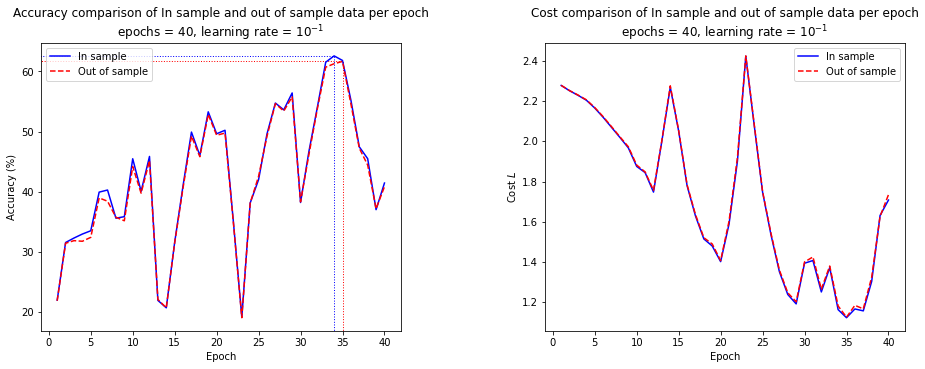

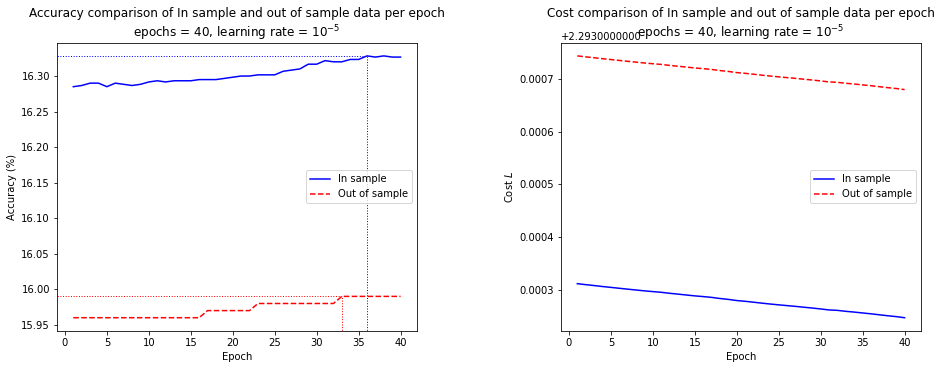

In [111]:
print("Min in-sample loss (i):", np.min(q112_acc_per_epoch_in_sample[0][1]))
print("Max in-sample accuracy (i):", np.max(q112_acc_per_epoch_in_sample[0][0]))

print("Min in-sample loss (ii):", np.min(q112_acc_per_epoch_in_sample[1][1]))
print("Max in-sample accuracy (ii):", np.max(q112_acc_per_epoch_in_sample[1][0]))

for i, learning_rate in enumerate([1e-1, 1e-5]):
    plot_in_out_acc_cost_graphs(
        q112_acc_per_epoch_in_sample[i], 
        q112_acc_per_epoch_out_sample[i], 
        epochs = 40, 
        learning_rate = learning_rate)

The first, perhaps unsurprising, observation about all the above networks is that both the accuracy and the loss of the in-sample data (on which the network was trained) trumps the out of sample data's by a visible margin. The loss of each of the networks showed an overall decreasing trend whose gradient was identical for both data sets, yet the offset favoured the in sample data.

For the first set of accuracies and losses, where the learning rate was set to $10^{-1}$, it is quite clear to see that the network was able to perform significantly better, when considering the maximum of their metrics, than when $10^{-3}$ was used. Indeed, whilst the network from part 1.1.1 was, in the same time frame, only able to achieve a maximal accuracy and minimum loss of (), whilst the newly trained network achieved 62.6% and 1.12 on epoch 34. This can be effectively attributed to the increased 'speed' of gradient descent given by this learning parameter. The greater the parameter the more bold the network is in moving away from the calculated gradient at its current iteration. However, it is quite clear that this has its downsides, namely a greater probability of it optimising in the wrong direction, overshooting the desired minimum due to the larger steps it takes. This is evident in the jagged nature of the accuracy and loss graph, whose general trend is increasing yet also oscillates wildly in its predictive capabilities. This is in stark contrast to the the slower learning rate, where each improvement is more meek but overall steadier and less likely to decrease. It is without question that a lower learning rate shows more uniform convergence whilst a larger learning rate may never truly converge, constantly missing the minimum of the loss function due its great steps.

The same analysis can be employed on the further lowered learning rate $10^{-5}$. Although the cost of the network was shown to decrease as a whole, it is without question that is severly underperformed when compared to the other two learning rates. In fact, when analysing the accuracy of the out of sample data, the graph shows discrete step-ups in accuracy followed by long plateaus as the epochs increase. This is to be expected, seeing as the calculation of accuracy involves choosing the networks greatest output as the category. For the network to predict differently, either its confidence in the previous prediction must decrease to the point where another classifcation is deemed more likely, the network learns to increase the likelyhood of another classification (asside from the one previously chosen) so that it is the greatest or a combination of the two (most likely). In this sense, there is a certain threshold by which the network must change so that any changes in accuracy may be observed. In this case, the coefficient term of the gradient descent is so small that the changes are only observed after a span of many epochs. The same is not true for the cost, as this is a parameter which is continuously decreased by the network. The cost in this case, is the most stable of all of the previous learning rates, showing the slightest deviation from a straight line. However, even after being trained for fourty epochs and approximately $40 \times 256 = 10240$ data points, roughly one sixth of the training data, the network does not show sufficient progress to extrapolate that its maximal accuracy may reach that of the other networks given a sufficient extension in its training epochs. Indeed, after 240 epochs it becomes inevitable that repeated training points are sampled, and with it increased risk of over-fitting.

In [98]:
np.random.seed(MASTER_SEED)

q113_network = deepcopy(q11_network_base)

q113_acc_per_epoch_in_sample  = [[], []]
q113_acc_per_epoch_out_sample = [[], []]

SGD(flat_x_train, 
    y_train, 
    q113_network, 
    LeakyReLU, 
    LeakyRelUPrime, 
    softmax, 
    CE_softmax_error,
    epochs=80, 
    batch_size=256, 
    learning_rate=1e-3,
    test_func=q1_general_accuracy_test(
        q113_acc_per_epoch_in_sample,
        q113_acc_per_epoch_out_sample
    ))

Epoch: [80/80][■■■■■■■■■■■■■■■■■■■■]100% Done!


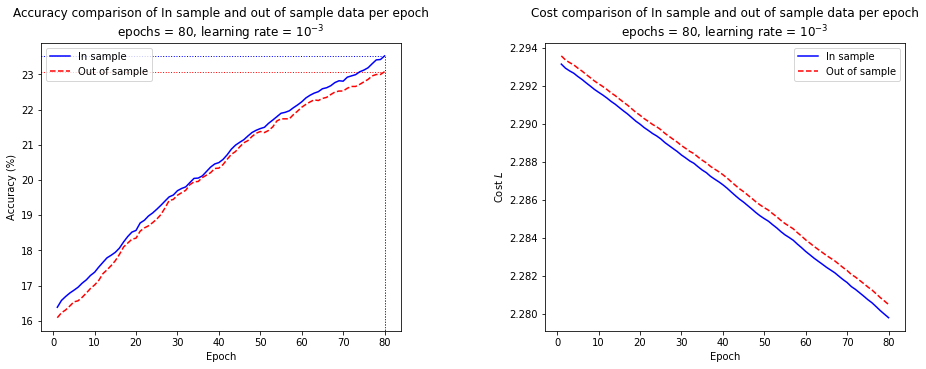

In [99]:
plot_in_out_acc_cost_graphs(
    q113_acc_per_epoch_in_sample, 
    q113_acc_per_epoch_out_sample, 
    epochs = 80, 
    learning_rate = 1e-3)

Increasing the number epochs, mostly, produces expected results. The network trained at 40 epochs showed a linear increase in its accuracy and similar decrease in its loss, hence a doubling of its training duration effectly double and halved its accuracy and loss respectively. The accuracy shows an ever so slight deviation from linear, slowly flattening in the larger epochs, most evident when considering the out of sample data. This is perhaps evidence that the network is approaching a minima and its gradient is proportionally decreasing in magnitude. However, in stark contrast to this, the cost does not, yet, show any significant 'flattening' in its trajectory, decreasing steadly across the epochs. Especially, when considering the out of sample data. This is a bit unsual seeing as one would expect the cost to be inversely proportional to the accuracy, however this may be evidence that the accuracy is merely going through a momentary reduction in rate of change.

In [100]:
def brute_force_train(X_train, y_train, network, activation_func, activation_prime, output_func, del_cost, learning_rate = 1e-3, test_func = identity_func, test_freq=1):
    """
    Performs gradient descent on and at every training point passed in. Automatically
    updates weights and biases of network passed in. 

    Args:
        X_train                       (np.array): Training data.
        y_train                       (np.array): Expected results for training data.
        network                          (tuple): Network as tuple of (weights, biases).
        activation_func     (Function(np.array)): Activation function for hidden layers.
        activation_prime    (Function(np.array)): Total derivative of 'activation_func'.
        output_func         (Function(np.array)): Activation function for output layer.
        del_cost  (Function(np.array, np.array)): Returns error of output layer.
        learning_rate          (float, optional): The learning rate. Defaults to 1e-3.
        test_func            (network, optional): Function called after gradient descent. Defaults to identity_func.
        test_freq                (int, optional): Frequency with which 'test_func' is called. Defaults to 1.
    """
    
    #Number of training points
    training_points = y_train.shape[0]

    for progress, (X, y) in enumerate(zip(X_train, y_train)):
        progress_bar(progress + 1, training_points, "Training point: ")

        pre_acts, post_acts = forward_propagate(network, activation_func, X)
        output = output_func(post_acts[-1])
        last_err = del_cost(output, y)

        del_ws, del_bs = back_propogate(network, last_err, pre_acts, post_acts, activation_prime)

        for layer, (del_w, del_b) in enumerate(zip(del_ws, del_bs)):
            network[0][layer] -= learning_rate * del_w
            network[1][layer] -= learning_rate * del_b

        if progress % test_freq == 0:
            test_func(network)

    print(" Done!")

In [101]:
brute_force_net = deepcopy(q11_network_base)

bf_acc_per_epoch_in_sample  = [[], []]
bf_acc_per_epoch_out_sample = [[], []]

brute_force_train(flat_x_train, 
    y_train, 
    brute_force_net, 
    LeakyReLU, 
    LeakyRelUPrime, 
    softmax, 
    CE_softmax_error,
    learning_rate=1e-3,
    test_func=q1_general_accuracy_test(
        bf_acc_per_epoch_in_sample,
        bf_acc_per_epoch_out_sample
    ), 
    test_freq=1500)

Training point: [60000/60000][■■■■■■■■■■■■■■■■■■■■]100% Done!


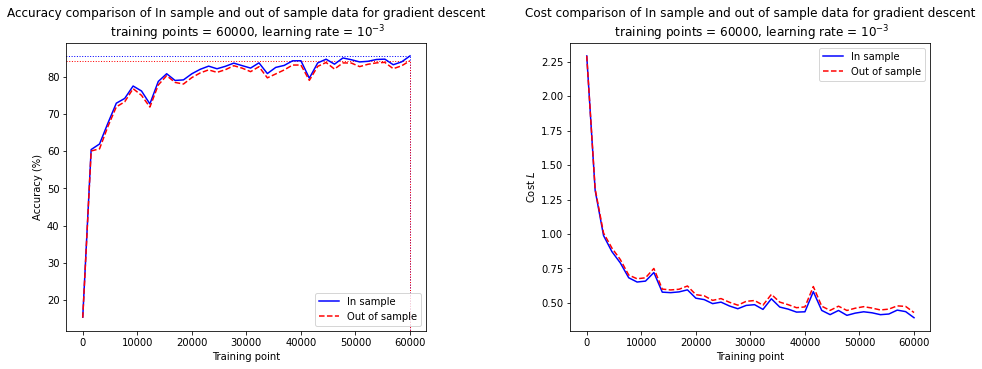

In [102]:
plot_in_out_acc_cost_graphs(
    bf_acc_per_epoch_in_sample, 
    bf_acc_per_epoch_out_sample, 
    epochs = flat_x_train.shape[0], 
    learning_rate = 1e-3)

The results above are a quick demonstration of the neural network's potential were it to have been fully trained on the entire dataset (The naïve implementation). It is interesting to use this approach to compare with the SGD algorithm, whereby it produces significantly better results at the cost of similarly greater computational expenditure and, although not exhibited in this example, a stronger risk of overfitting. This computation is, perhaps, indicative of the results expected were one to further increase the number of epochs.  

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

In [47]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LeakyReLU, Dropout

In [48]:

tf.random.set_seed(MASTER_SEED)

leaky = LeakyReLU(alpha=1e-2)
q121_model = tf.keras.Sequential([
    Conv2D(8,  (3, 3), activation=leaky, input_shape=(28, 28, 1)),
    Conv2D(8,  (3, 3), activation=leaky),
    Conv2D(16, (3, 3), activation=leaky),
    Conv2D(16, (3, 3), activation=leaky),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation=leaky),
    Dense(10, activation=tf.keras.activations.softmax)
])

q121_model.summary()
q121_model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
    metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_6 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                      

In [9]:
tf.random.set_seed(MASTER_SEED)

early_stopping  = tf.keras.callbacks.EarlyStopping(patience=15, monitor="val_accuracy")

q121_history = q121_model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=256, 
    epochs=40, 
    verbose=1, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],
    use_multiprocessing = True)

Epoch 1/40
235/235 [==============================] - 37s 156ms/step - loss: 2.2055 - accuracy: 0.1503 - val_loss: 2.1517 - val_accuracy: 0.1944
Epoch 2/40
235/235 [==============================] - 32s 135ms/step - loss: 2.0096 - accuracy: 0.3257 - val_loss: 1.7590 - val_accuracy: 0.4715
Epoch 3/40
235/235 [==============================] - 31s 132ms/step - loss: 1.3505 - accuracy: 0.5520 - val_loss: 1.0434 - val_accuracy: 0.5942
Epoch 4/40
235/235 [==============================] - 37s 157ms/step - loss: 0.9189 - accuracy: 0.6535 - val_loss: 0.8695 - val_accuracy: 0.6639
Epoch 5/40
235/235 [==============================] - 34s 143ms/step - loss: 0.8072 - accuracy: 0.6935 - val_loss: 0.7947 - val_accuracy: 0.7008
Epoch 6/40
235/235 [==============================] - 31s 131ms/step - loss: 0.7584 - accuracy: 0.7124 - val_loss: 0.7645 - val_accuracy: 0.7056
Epoch 7/40
235/235 [==============================] - 31s 130ms/step - loss: 0.7297 - accuracy: 0.7231 - val_loss: 0.7390 - val_ac

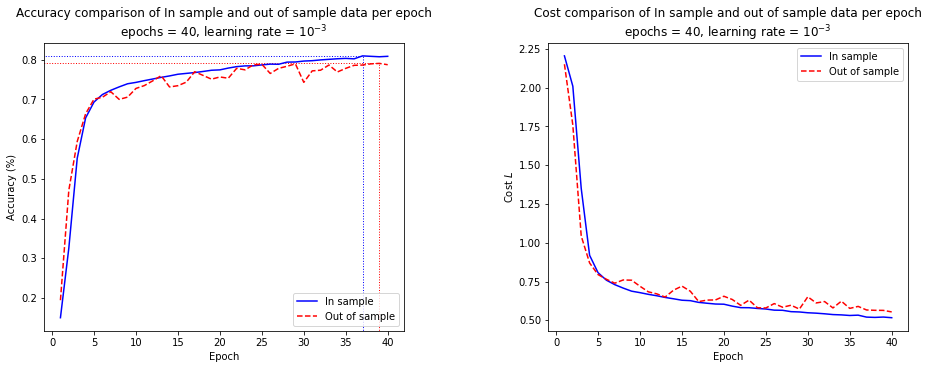

In [35]:
q121_data = q121_history.history
plot_in_out_acc_cost_graphs(
    [q121_data["accuracy"]    , q121_data["loss"]], 
    [q121_data["val_accuracy"], q121_data["val_loss"]], 
    epochs=40, 
    learning_rate=1e-3)

For the following set of networks, a new approach will be considered. Namely, dropout. This method was envisioned to help reduce overfitting of a dataset by randomly disconnecting the output of the perceptrons on a particular layer of choice, while maintaining the aggregate activation entering the next. This is done under the assumption that the summed strength of the activations of each perceptron are similar, hence a simple scaling is performed on the output of every non-deactivated neuron:



In [49]:

def get_q122_model(dropout_prob):
    leaky = LeakyReLU(alpha=1e-2)
    model = tf.keras.Sequential([
        Conv2D(8,  (3, 3), activation=leaky, input_shape=(28, 28, 1)),
        Conv2D(8,  (3, 3), activation=leaky),
        Conv2D(16, (3, 3), activation=leaky),
        Conv2D(16, (3, 3), activation=leaky),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(64, activation=leaky),
        Dropout(dropout_prob),
        Dense(10, activation=tf.keras.activations.softmax)
    ])

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
        metrics=["accuracy"])

    return model

In [ ]:
from matplotlib import cm

In [ ]:
q122_acc_per_dropout_prob = []
#Values in closed interval [0.1, 0.9]
prob_scan_vals = np.linspace(0.1, 0.9, 9)

#Scan for optimal dropout probability
for probability in prob_scan_vals:
    progress_bar(f"{probability:.1f}" , prob_scan_vals[-1], "Dropout probability: ")

    # Ensures that the same network weights and biases are assigned and SGD
    # is performed on the same mini batches, hence only independant parameter
    # is the dropout probability
    tf.random.set_seed(MASTER_SEED)

    model = get_q122_model(probability)
    history = model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=256, 
        epochs=40, 
        verbose=0, 
        validation_split = 0.2) #2:8, validation:training split

    q122_acc_per_dropout_prob.append(history.history["val_accuracy"])

print(" Done!")



Dropout probability: [0.9/0.9][■■■■■■■■■■■■■■■■■■■■]100% Done!


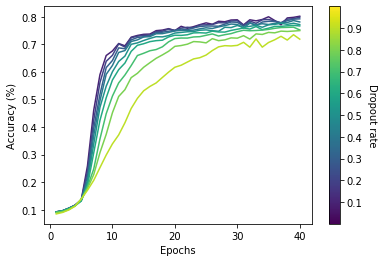

In [ ]:
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

for dropout_rate, dropout_acc_per_epoch in zip(prob_scan_vals, q122_acc_per_dropout_prob):
    plt.plot(
        np.linspace(1, 40, 40), 
        dropout_acc_per_epoch, 
        color=cm.viridis(dropout_rate), 
        label = f"d-rate: {dropout_rate:.1f}")

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cm.viridis), ticks=prob_scan_vals)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Dropout rate", rotation=270)
plt.show()

In [42]:
# The maximum accuracy achieved during training on the validation set will
# be used as the metric for choosing the optimal dropout
q122_max_acc_per_dropout = np.max(q122_acc_per_dropout_prob, axis=1)

plt.figure()
plt.title("Max accuracy over 40 epochs per dropout rate")
plt.xlabel("Dropout rate")
plt.ylabel("Accuracy (%)")
plt.plot(prob_scan_vals, q122_max_acc_per_dropout, color="red")
plt.show()

q122_optimal_dropout = prob_scan_vals[np.argmax(q122_max_acc_per_dropout)]
print("Optimal droupout:", q122_optimal_dropout)

NameError: name 'q122_acc_per_dropout_prob' is not defined

It is quite clear from the above graphs that the combination of the training set and the network architecture seem to favour a lower dropout rate. Indeed, the graph immediately above suggests a non-linear monotonic decrease in the effectiveness of the network as the probability of activation failure increases. Seeing as dropout is a measure designed against overfitting, the natural conclusion is that the network architecture is a good fit for the problem at hand.

In [53]:
q122_optimal_dropout = 0.1
q122_optimal_model = get_q122_model(q122_optimal_dropout)
q122_optimal_model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=256, 
        epochs=40, 
        verbose=1, 
        validation_data=(x_test, y_test)) #2:8, validation:training split

Epoch 1/40
 18/235 [=>............................] - ETA: 47s - loss: 2.3032 - accuracy: 0.0905

KeyboardInterrupt: 

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for dimensionality reduction  [^](#outline)

<a name="q32"></a>

## 3.2 Community detection [^](#outline)